# Anomaly Detection

In [8]:
# import sys
import sys
sys.path.append("/home/ladin/Projects/research/botnet-traffic-analysis/")

# Jupyter data visualization
from IPython import display

# data handling
from sklearn.preprocessing import normalize
from sklearn.utils import resample
import numpy as np
import pandas as pd

# machine learning
from sklearn.ensemble import RandomForestClassifier

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import plot, axis, show, pcolor, colorbar, bone
from scipy.stats import gaussian_kde

# SOM
import minisom
import somoclu
from SAD.anomaly_detection import AnomalyDetection

# hyperparameter tuning
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

# feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# other
import time
import os

In [9]:
from utils.datasets import get_all_files

In [10]:
def plot_som(som, data, target=None):
    plt.figure(figsize=(16, 12))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['o','s','D','+','v','p','*','x']
    colors = ['r','g','b','y','pink','orange','purple','grey']
    if target is not None:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
                markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
            axis([0, som._weights.shape[0], 0, som._weights.shape[1]])
        show()
    else:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[0], markerfacecolor='None',
                markeredgecolor=colors[0], markersize=12, markeredgewidth=2)
        show()

## Malware detection via Training and Tuning SOMs

In [11]:
# Load data
from utils.config import dn_nbaiot, nbaiot_1K_data_path, nbaiot_5K_data_path, nbaiot_10K_data_path, nbaiot_20K_data_path
from utils.datasets import get_all_files

In [12]:
choose_folder = nbaiot_10K_data_path
all_files = get_all_files(folder=choose_folder)

In [13]:
def get_data_by_device_type(index):
    device_file = [file for file in all_files if str(index) in file]
    df_benign = pd.DataFrame()
    df_ack = pd.DataFrame()
    df_scan = pd.DataFrame()
    df_syn = pd.DataFrame()
    df_udp = pd.DataFrame()
    for filename in device_file:
        df_c = pd.read_csv(os.path.join(choose_folder, filename))
        rows = df_c.shape[0]
        if 'benign' in filename:
            df_benign = pd.concat([df_benign.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'ack' in filename:
            df_ack = pd.concat([df_ack.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'scan' in filename:
            df_scan = pd.concat([df_scan.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'syn' in filename:
            df_syn = pd.concat([df_syn.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'udp' in filename:
            df_udp = pd.concat([df_udp.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
    return df_benign, df_ack, df_scan, df_syn, df_udp
#     print(device_file)

In [14]:
df_benign, df_ack, df_scan, df_syn, df_udp = get_data_by_device_type(1)

In [15]:
# preprocess data
df_benign['class'] = 0
df_ack['class'] = 1
df_scan['class'] = 2
df_syn['class'] = 3
df_udp['class'] = 4

In [16]:
data_benign = normalize(df_benign.iloc[:, 0:-1])
data_ack = normalize(df_ack.iloc[:, 0:-1])
data_scan = normalize(df_scan.iloc[:, 0:-1])
data_syn = normalize(df_syn.iloc[:, 0:-1])
data_udp = normalize(df_udp.iloc[:, 0:-1])

In [17]:
target_benign = df_benign.iloc[:, -1].astype(int)
target_ack = df_ack.iloc[:, -1].astype(int)
target_scan = df_scan.iloc[:, -1].astype(int)
target_syn = df_syn.iloc[:, -1].astype(int)
target_udp = df_udp.iloc[:, -1].astype(int)

In [18]:
df_benign.head()

,Unnamed: 0,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,class
0,0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
1,1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,...,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,0
2,2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,...,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,0
3,3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,...,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,0
4,4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0


In [19]:
data = np.vstack([data_benign, data_ack, data_scan, data_syn, data_udp])
target = np.hstack([target_benign, target_ack, target_scan, target_syn, target_udp])

In [20]:
# shuffle
data = resample(data)
target = resample(target)

In [21]:
print(np.isnan(data).any())
print(np.isnan(target).any())

False
False


# Creating and training SOM

In [22]:
n = 5000
x = int(1/2*np.sqrt(n))
som_og = minisom.MiniSom(x=x,
                        y=x,
                        input_len=data_benign.shape[1],
                        sigma=2,
                        learning_rate=0.5)

In [23]:
som_og.train_random(data_benign, 100)

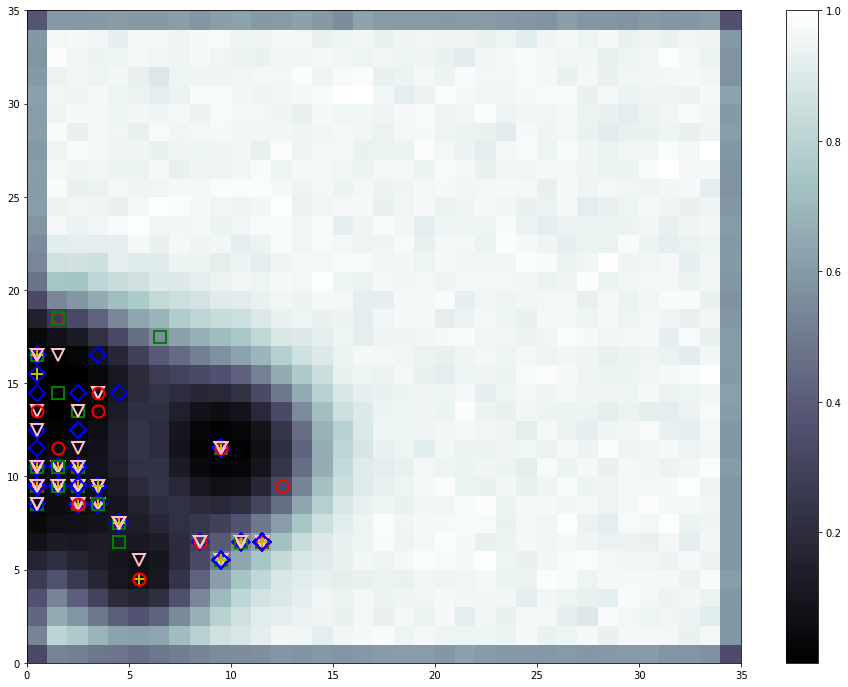

In [24]:
plot_som(som_og, data[0:n, :], target[0:n])

# Tree-based feature selection

In [25]:
clf = ExtraTreesClassifier()
clf.fit(data, target)

ExtraTreesClassifier()

In [26]:
sfm = SelectFromModel(clf, prefit=True)

In [27]:
data_benign_new = sfm.transform(data_benign)
data_ack_new = sfm.transform(data_ack)
data_scan_new = sfm.transform(data_scan)
data_syn_new = sfm.transform(data_syn)
data_udp_new = sfm.transform(data_udp)
data_new = sfm.transform(data)

In [28]:
print("Number of feature: ", data_new.shape[1])

Number of feature:  12


In [29]:
space = {
    'sigma': hp.uniform('sigma', 5, 10),
    'learning_rate': hp.uniform('learning_rate', 0.05, 5),
    'x': hp.uniform('x', 20, 50)
}

In [30]:
def som_fn(space):
    sig = space['sigma']
    learning_rate = space['learning_rate']
    x = int(space['x'])
    val = minisom.MiniSom(x=x,
                         y=x,
                         input_len=data_benign_new.shape[1],
                         sigma=sig,
                         learning_rate=learning_rate,
                         ).quantization_error(data_benign_new[0:100, :])
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [31]:
trials = Trials()

In [32]:
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=1200,
           trials=trials)

{'learning_rate': 3.358748685434644, 'sigma': 7.275093475540195, 'x': 31.760299541271028}
0.8159229718502894                                      
{'learning_rate': 1.0507099133363327, 'sigma': 8.667714204229227, 'x': 28.593477214808587}
0.9015219572561015                                                                
{'learning_rate': 0.2375690353990626, 'sigma': 5.962209634075763, 'x': 40.51667805379677}
0.8473021862915853                                                                
{'learning_rate': 0.7745354502701263, 'sigma': 5.177403490155952, 'x': 34.043122342732595}
0.8827434821550392                                                                
{'learning_rate': 3.816638701671303, 'sigma': 7.037271880012335, 'x': 26.145452033932557}
0.8985217516307058                                                                
{'learning_rate': 1.6054615015185367, 'sigma': 8.277703609042355, 'x': 30.25497948823131}
0.8528263043470795                                                   

{'learning_rate': 2.203272396729339, 'sigma': 8.765276798724681, 'x': 31.029865466482615}
0.8875960626083778                                                                 
{'learning_rate': 3.3145236620032215, 'sigma': 6.595124051571931, 'x': 20.196755352091866}
0.9157609676816902                                                                 
{'learning_rate': 2.585014604203426, 'sigma': 8.274120060834578, 'x': 32.18273559165623}
0.9016563466638787                                                                 
{'learning_rate': 1.797837183796776, 'sigma': 9.337355865992324, 'x': 27.985282486879562}
0.8901874702778673                                                                 
{'learning_rate': 4.51474769847812, 'sigma': 6.105027314334087, 'x': 29.345238923214133}
0.8720693747363224                                                                 
{'learning_rate': 4.911742731915431, 'sigma': 6.322068613221627, 'x': 25.85638927918447}
0.8642345270621015                        

{'learning_rate': 2.786227270710505, 'sigma': 5.794269984535901, 'x': 38.85414184331821}
0.8796089681310026                                                                  
{'learning_rate': 4.703452482607207, 'sigma': 8.936167059889282, 'x': 21.29099272012757}
0.8867289556591155                                                                  
{'learning_rate': 4.345293659280512, 'sigma': 6.506192227356808, 'x': 28.870032598833145}
0.8903685054250361                                                                  
{'learning_rate': 4.923565820423026, 'sigma': 8.375505184458975, 'x': 45.14036563842443}
0.8500639815334396                                                                  
{'learning_rate': 3.5594812292968867, 'sigma': 7.264821326331445, 'x': 24.679365942773813}
0.8513218841925696                                                                  
{'learning_rate': 3.74700382304946, 'sigma': 7.5137525084227, 'x': 37.249378431507864}
0.8608248479984991                      

0.8856795185412661                                                                  
{'learning_rate': 3.813968336205069, 'sigma': 8.903685797634301, 'x': 36.44895042493907}
0.8401467047700041                                                                  
{'learning_rate': 4.465279880238021, 'sigma': 8.377149813188058, 'x': 39.92443532512781}
0.8677962566894923                                                                  
{'learning_rate': 3.1983566646470765, 'sigma': 8.682779365834168, 'x': 22.651503845776}
0.7760057587146322                                                                  
{'learning_rate': 4.05873996979043, 'sigma': 7.929187467560997, 'x': 41.226562770504735}
0.8296227093710391                                                                  
{'learning_rate': 3.6472168759705195, 'sigma': 7.572000808985044, 'x': 40.579441196834544}
0.8436337086304525                                                                  
{'learning_rate': 4.718432416220783, 'sigma'

0.8652533254910836                                                                  
{'learning_rate': 4.082652451777741, 'sigma': 7.187697781295403, 'x': 21.946829926443755}
0.8890416497209344                                                                  
{'learning_rate': 4.610146339414667, 'sigma': 8.128970373249155, 'x': 46.38673815010578}
0.8318664045677907                                                                  
{'learning_rate': 3.342277604087841, 'sigma': 7.460921523884417, 'x': 40.20928059700671}
0.8503821351489484                                                                  
{'learning_rate': 3.720418671925281, 'sigma': 7.6935978289293345, 'x': 20.038694113208685}
0.8812398755529104                                                                  
{'learning_rate': 1.7123837446899184, 'sigma': 7.59789780283863, 'x': 35.076316203243536}
0.8860712168147828                                                                  
{'learning_rate': 4.532271759726066, 'sig

0.8397853721761075                                                                  
{'learning_rate': 3.2941341662385293, 'sigma': 5.690220358027315, 'x': 49.44093250040644}
0.8696566309198686                                                                  
{'learning_rate': 2.563536894575665, 'sigma': 5.503812199138745, 'x': 47.4688163007953}
0.8373727037810326                                                                  
{'learning_rate': 2.790331746242291, 'sigma': 5.366686871946017, 'x': 49.787250057131004}
0.8582655480734352                                                                  
{'learning_rate': 3.160886065585209, 'sigma': 6.792041240055173, 'x': 43.69407447933258}
0.8370871817469682                                                                  
{'learning_rate': 3.0018519738305085, 'sigma': 5.998084116780028, 'x': 45.90961517423646}
0.8399203371490954                                                                  
{'learning_rate': 2.2447780381707387, 'sigm

0.8139500707775369                                                                  
{'learning_rate': 4.239856360363838, 'sigma': 7.538745500055913, 'x': 45.35449686458918}
0.8919518477126293                                                                  
{'learning_rate': 4.126947612209241, 'sigma': 6.911106543285427, 'x': 47.61017633444388}
0.8616947847242679                                                                  
{'learning_rate': 4.834453931722087, 'sigma': 7.203228519250573, 'x': 42.28198265508289}
0.8745978637646961                                                                  
{'learning_rate': 4.33391360270222, 'sigma': 6.462366430010242, 'x': 46.694287014420134}
0.8631586267896134                                                                  
{'learning_rate': 4.986316649275539, 'sigma': 7.688040565840552, 'x': 40.658176433239085}
0.8027583791784043                                                                  
{'learning_rate': 4.159473549064591, 'sigma'

0.8719941688546673                                                                  
{'learning_rate': 4.19797017591709, 'sigma': 6.550578391074641, 'x': 37.977810485908016}
0.9053281778976112                                                                  
{'learning_rate': 4.0678541358451135, 'sigma': 7.1866466101549795, 'x': 45.206002520938355}
0.8036056319453015                                                                  
{'learning_rate': 4.738244217881511, 'sigma': 5.894217148682937, 'x': 48.36634907502276}
0.8402236847546521                                                                  
{'learning_rate': 3.4518375668210077, 'sigma': 5.3697197293929975, 'x': 43.31709667855107}
0.788391873398987                                                                   
{'learning_rate': 3.7828945731615455, 'sigma': 7.819856624687831, 'x': 46.60697320948313}
0.791086619335677                                                                   
{'learning_rate': 4.84273994983758, 'si

0.8687435664411299                                                                  
{'learning_rate': 3.5578399518183974, 'sigma': 6.327696502275186, 'x': 47.45862565119591}
0.8778952365267878                                                                  
{'learning_rate': 2.9317838809814933, 'sigma': 6.176691687439574, 'x': 48.92404379160164}
0.8718792831762847                                                                  
{'learning_rate': 3.195369458862969, 'sigma': 6.913343917583243, 'x': 49.991892931597754}
0.8518534708751954                                                                  
{'learning_rate': 3.5125213484736197, 'sigma': 6.032079938016056, 'x': 45.75098474421827}
0.8711704195178784                                                                  
{'learning_rate': 2.829191516347273, 'sigma': 6.42679917618004, 'x': 48.12941031486274}
0.8422806281509252                                                                  
{'learning_rate': 3.3459488288270394, 'sig

0.8832303948833348                                                                  
{'learning_rate': 3.669524874645, 'sigma': 7.230983504895983, 'x': 43.68391303917653}
0.8703721176839286                                                                  
{'learning_rate': 3.7684769085422944, 'sigma': 6.3721842171537695, 'x': 44.89552854466321}
0.8346834660530534                                                                  
{'learning_rate': 2.7832172253938445, 'sigma': 5.938155384135756, 'x': 43.05747367356255}
0.8894766288289808                                                                  
{'learning_rate': 3.3390298253769517, 'sigma': 7.531406194216069, 'x': 47.97666764277985}
0.8613896241520649                                                                  
{'learning_rate': 4.238768825562629, 'sigma': 6.231849322375625, 'x': 46.95912638720204}
0.8884166691553643                                                                  
{'learning_rate': 2.5649131801346092, 'sigma

0.81356117655227                                                                    
{'learning_rate': 0.4595745521906739, 'sigma': 5.607551109591914, 'x': 47.20894873799574}
0.8280570703461764                                                                  
{'learning_rate': 0.5072538772030054, 'sigma': 5.701998113909484, 'x': 48.26338631697642}
0.8694519343781302                                                                  
{'learning_rate': 0.9747460226432468, 'sigma': 5.318665286415353, 'x': 47.710632684756995}
0.8472486344742685                                                                  
{'learning_rate': 0.6884187882633724, 'sigma': 5.936863010631129, 'x': 45.51790498687044}
0.8907158986345952                                                                  
{'learning_rate': 0.15417561101859256, 'sigma': 6.6406966713871025, 'x': 46.45149671026284}
0.8613173595825364                                                                  
{'learning_rate': 1.4805620095133876,

0.8479807566323507                                                                   
{'learning_rate': 0.3881739193630077, 'sigma': 5.4316589570998675, 'x': 48.27321783518813}
0.831101879252634                                                                    
{'learning_rate': 0.5970988750756131, 'sigma': 5.4759042838444385, 'x': 47.72628466106905}
0.863725749679608                                                                    
{'learning_rate': 0.19009315277542777, 'sigma': 6.163775720188456, 'x': 49.22680092176219}
0.8203720475463423                                                                   
{'learning_rate': 0.5109041304973523, 'sigma': 6.671938067385903, 'x': 48.71503624097096}
0.8439806921242088                                                                   
{'learning_rate': 0.4525865306282792, 'sigma': 6.318362910871973, 'x': 46.75477696194027}
0.8110983133990213                                                                   
{'learning_rate': 0.67746806907

{'learning_rate': 3.435520796798909, 'sigma': 6.161782561140347, 'x': 45.93895065659001}
0.8230351851295974                                                                   
{'learning_rate': 0.3482742187659704, 'sigma': 6.343848575885373, 'x': 38.4909168232855}
0.8912392252588717                                                                   
{'learning_rate': 2.9415234233270287, 'sigma': 5.601738355583558, 'x': 49.373404291111584}
0.8623311376605416                                                                   
{'learning_rate': 0.9338352679424821, 'sigma': 6.689090784160606, 'x': 48.589609364423445}
0.8451168073330045                                                                   
{'learning_rate': 3.262029341038316, 'sigma': 5.435779520655844, 'x': 44.9373038761819}
0.7969208800162617                                                                   
{'learning_rate': 3.781567188776869, 'sigma': 6.9252295771974355, 'x': 47.06646488578261}
0.8263073273248852              

In [33]:
print('Best: {}'.format(best))

Best: {'learning_rate': 3.4805487160414423, 'sigma': 6.062715109497231, 'x': 43.7354129223058}


In [34]:
som_turned = minisom.MiniSom(x=45,
                            y=45,
                            input_len=data_benign_new.shape[1],
                            sigma=8.253131141914132,
                            learning_rate=2.0572075132895598)

In [35]:
som_turned.train_random(data_benign_new, 1000)

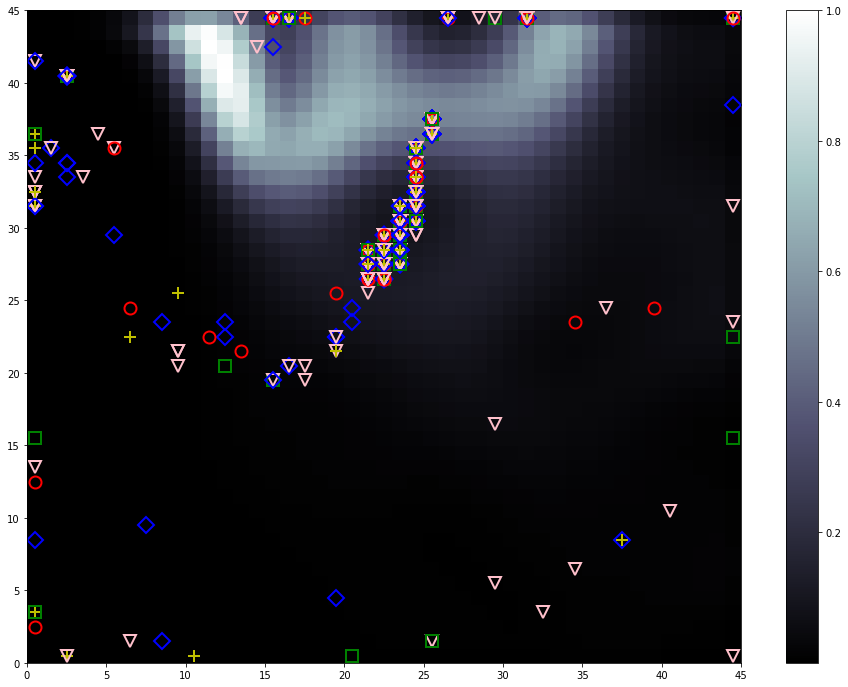

In [36]:
n = 10000
plot_som(som_turned, data_new[0:n, :], target[0:n])

## Somoclu

Flexible library with many options.

Pros:
- easy to identify clusters
- PCA initialization instead of random
- includes K-means clustering algorithm from sklearn
- evolving maps

Cons:
- long time to train.

In [37]:
som_somoclu = somoclu.Somoclu(n_columns=45,
                             n_rows=45,
                             std_coeff=8.2,
                             verbose=1)

In [38]:
som_somoclu.train(data_new[0:1000, :],
                 scale0=0.2,
                 scaleN=0.02)

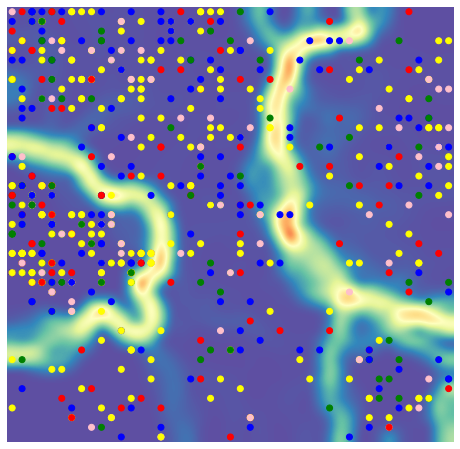

<module 'matplotlib.pyplot' from '/home/ladin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [39]:
colors = ['red', 'green', 'blue', 'pink', 'yellow']
color_list = [colors[t] for t in target[0:1000]]
som_somoclu.view_umatrix(bestmatches=True, bestmatchcolors=color_list)

# Anomaly detection with SOM and K-nearest neighbors

In [40]:
def get_anomalies(benign_metrics, anomaly_metrics, alpha=3, return_outliers=True):
    '''
    Get anomalies from evaluation metric
    '''
    limit = np.mean(benign_metrics)+np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics) > limit)
    print("Determined: ", len(outliers)/len(anomaly_metrics)*100, "% as anomaly")
    if return_outliers:
        return outliers

In [41]:
def minimize_anomaly(benign_metrics, anomaly_metrics, alpha=3):
    '''
    Objective function to be minimized durinig tuning
    calculates percent error in classifying anomalies based on steady state metrics.
    '''
    limit = np.mean(benign_metrics) + np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics)>limit)
    pct_anomaly = len(outliers)/len(anomaly_metrics)
    return 1 - pct_anomaly

In [42]:
# print(minimize_anomaly(benign_metrics=benign_metrics, anomaly_metrics=anomaly_metrics))

In [43]:
training = data_benign_new
evaluation = data_new

In [44]:
# initialize our anomaly detector with some arbitrary parameters
anomaly_detector = AnomalyDetection(shape=(10,10),
                                   input_size=training.shape[1],
                                   learning_rate=8,
                                   learning_decay=0.001,
                                   initial_radius=2,
                                   radius_decay=0.001,
                                   min_number_per_bmu=0,
                                   number_of_neighbors=3)
# fit the anomaly detector and apply to the evaluation data
anomaly_detector.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[1.81613371e-05, 4.98372977e-08, 1.09536577e-07, ...,
        1.36864434e-07, 1.00206020e-03, 9.99985684e-01],
       [3.36172032e-04, 6.60816559e-07, 1.45449350e-06, ...,
        1.55556339e-06, 3.10922481e-03, 9.99956839e-01],
       [3.81248401e-03, 2.79382139e-06, 1.12413951e-05, ...,
        2.60391280e-05, 2.50342690e-03, 9.99900115e-01],
       ...,
       [9.95201989e-01, 4.63894153e-06, 9.85488496e-06, ...,
        6.56246739e-06, 1.18224214e-04, 5.01875842e-04],
       [9.94829967e-01, 4.60386707e-06, 7.76693371e-06, ...,
        4.71942660e-05, 1.35580719e-03, 3.71337149e-03],
       [9.92486531e-01, 3.77617995e-06, 1.30961278e-05, ...,
        5.40082845e-05, 4.60862589e-03, 1.19760687e-02]])

In [45]:
# set limits
benign_metrics = anomaly_detector.evaluate(data_benign_new)
alpha = 3
sd_benign = np.std(benign_metrics)
mean_benign = np.mean(benign_metrics)
lim_benign = mean_benign + alpha*sd_benign
pct_benign = np.percentile(benign_metrics, 99.7)

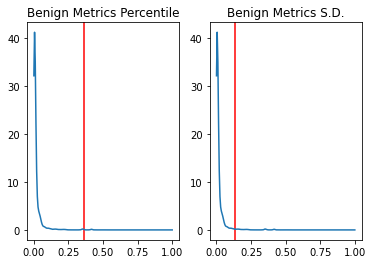

In [46]:
# visualizing benign
density = gaussian_kde(benign_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics S.D.")
plt.show()

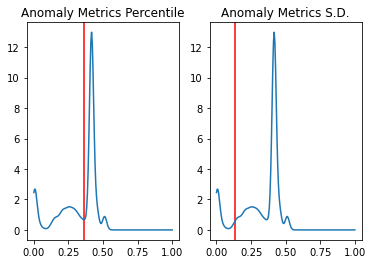

In [47]:
# Visualizing all anomalies
anomaly_metrics = anomaly_detector.evaluate(evaluation)
density = gaussian_kde(anomaly_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics S.D.")
plt.show()

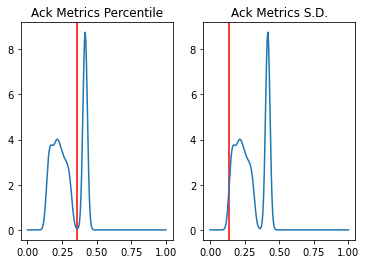

In [48]:
# Visualizing all anomalies
ack_metrics = anomaly_detector.evaluate(data_ack_new)
density = gaussian_kde(ack_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Ack Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Ack Metrics S.D.")
plt.show()

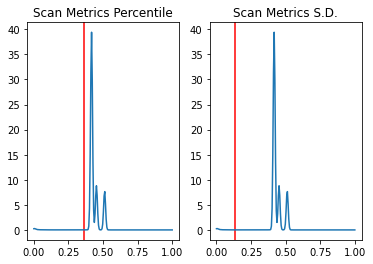

In [49]:
# Visualizing all anomalies
scan_metrics = anomaly_detector.evaluate(data_scan_new)
density = gaussian_kde(scan_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Scan Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Scan Metrics S.D.")
plt.show()

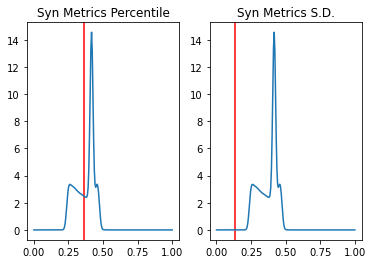

In [50]:
# Visualizing all anomalies
syn_metrics = anomaly_detector.evaluate(data_syn_new)
density = gaussian_kde(syn_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Syn Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Syn Metrics S.D.")
plt.show()

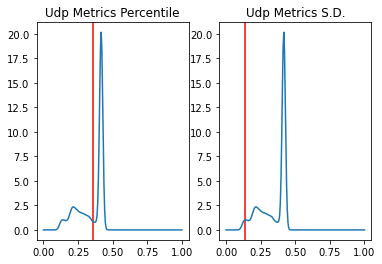

In [51]:
# Visualizing all anomalies
udp_metrics = anomaly_detector.evaluate(data_udp_new)
density = gaussian_kde(udp_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Udp Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Udp Metrics S.D.")
plt.show()

In [52]:
metrics = [benign_metrics, anomaly_metrics, ack_metrics, scan_metrics, syn_metrics, udp_metrics]
metric_names = ['benign', 'all alnomalies', 'ack', 'scan', 'syn', 'udp']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics, metric, alpha, False)

benign
Determined:  1.83 % as anomaly
all alnomalies
Determined:  86.58375000000001 % as anomaly
ack
Determined:  100.0 % as anomaly
scan
Determined:  99.14 % as anomaly
syn
Determined:  100.0 % as anomaly
udp
Determined:  97.77 % as anomaly


# Hyperparameter tuning

In [53]:
import time
start_time = time.time()

space = {
    'n_neighbors': hp.uniform('n_neighbors', 1, 3),
    'learning_rate': hp.uniform('learning_rate', 0.005, 10),
    'learning_decay': hp.uniform('learning_decay', 0.00001, 0.1),
    'initial_radius': hp.uniform('initial_radius', 1, 10),
    'radius_decay': hp.uniform('radius_decay', 0.00001, 0.1),
    'x': hp.uniform('x', 10, 50),
    'minNumberPerBmu': hp.uniform('minNumberPerBmu', 0, 10)
}

In [54]:
def anomaly_fn(space):
    n_neighbors = int(space['n_neighbors'])
    learning_rate = space['learning_rate']
    learning_decay = space['learning_decay']
    initial_radius = int(space['initial_radius'])
    radius_decay = space['radius_decay']
    x = int(space['x'])
    minNumberPerBmu = int(space['minNumberPerBmu'])
    
    anomaly_detector = AnomalyDetection(shape=(x, x),
                                       input_size=training.shape[1],
                                       learning_rate=learning_rate,
                                       learning_decay=learning_decay,
                                       initial_radius=initial_radius,
                                       radius_decay=radius_decay,
                                       min_number_per_bmu=minNumberPerBmu,
                                       number_of_neighbors=n_neighbors)
    anomaly_detector.fit(training, 5000)
    a_metrics = anomaly_detector.evaluate(evaluation)
    b_metrics = anomaly_detector.evaluate(training)
    val = minimize_anomaly(b_metrics, a_metrics, alpha=3)
    
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [55]:
trials = Trials()
best = fmin(fn=anomaly_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.299672426739203, 'learning_decay': 0.003355636128308682, 'learning_rate': 4.355006386721691, 'minNumberPerBmu': 9.986001747001787, 'n_neighbors': 1.584594623697075, 'radius_decay': 0.04083723628944305, 'x': 36.19930694156736}
0.243                                                  
  1%|          | 1/100 [00:06<11:28,  6.96s/trial, best loss: 0.243]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.382555679545862, 'learning_decay': 0.051242136519308444, 'learning_rate': 0.01814635066703105, 'minNumberPerBmu': 1.3444446212294325, 'n_neighbors': 2.6683069337043017, 'radius_decay': 0.09541607400139789, 'x': 22.907099375761018}
0.9022749999999999                                                  
  2%|▏         | 2/100 [00:10<07:57,  4.87s/trial, best loss: 0.243]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.30136051349783, 'learning_decay': 0.08400597395370626, 'learning_rate': 7.267480565936513, 'minNumberPerBmu': 3.9370115792487614, 'n_neighbors': 2.3124978267397247, 'radius_decay': 0.05210270278413051, 'x': 39.05119498249628}
0.28298749999999995                                                 
  3%|▎         | 3/100 [00:16<08:38,  5.35s/trial, best loss: 0.243]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.492570973677609, 'learning_decay': 0.08073535085468668, 'learning_rate': 2.205683090904145, 'minNumberPerBmu': 3.0666063061652657, 'n_neighbors': 1.9162019033516322, 'radius_decay': 0.05514846036215233, 'x': 36.37947447640653}
0.15946249999999995                                                 
  4%|▍         | 4/100 [00:21<08:30,  5.31s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.4807612219445785, 'learning_decay': 0.05653407665416823, 'learning_rate': 0.6809218453271616, 'minNumberPerBmu': 8.188783368143715, 'n_neighbors': 2.6242808386970324, 'radius_decay': 0.07508727964738936, 'x': 38.662259910954845}
0.734675                                                                          
  5%|▌         | 5/100 [00:27<08:36,  5.43s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.7530331511023984, 'learning_decay': 0.01596285850522772, 'learning_rate': 5.554565558772312, 'minNumberPerBmu': 5.357358115991532, 'n_neighbors': 2.470617728600245, 'radius_decay': 0.08065461898400092, 'x': 46.185344227296945}
0.2990125                                                                         
  6%|▌         | 6/100 [00:34<09:30,  6.07s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.076760765142924, 'learning_decay': 0.0921941745643521, 'learning_rate': 2.9073578227599874, 'minNumberPerBmu': 0.18093506952075233, 'n_neighbors': 2.4722881809374364, 'radius_decay': 0.014268751008059835, 'x': 13.570198016875988}
0.2542875                                                                         
  7%|▋         | 7/100 [00:37<07:46,  5.02s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.5086553196239905, 'learning_decay': 0.09763959586179115, 'learning_rate': 7.646532629864065, 'minNumberPerBmu': 7.20178842383599, 'n_neighbors': 2.253072684269728, 'radius_decay': 0.03482467844440186, 'x': 17.244110274320448}
0.2780125                                                                         
  8%|▊         | 8/100 [00:39<06:27,  4.21s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.402447752706109, 'learning_decay': 0.07777055685966514, 'learning_rate': 7.9479817458156665, 'minNumberPerBmu': 6.814066258885085, 'n_neighbors': 2.820754819185347, 'radius_decay': 0.016456108719853393, 'x': 20.574969380032464}
0.8189875                                                                         
  9%|▉         | 9/100 [00:42<05:46,  3.80s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.295421307522503, 'learning_decay': 0.08449282270595461, 'learning_rate': 5.187564524947216, 'minNumberPerBmu': 3.508543222455528, 'n_neighbors': 1.9528664569519634, 'radius_decay': 0.03800826791217895, 'x': 41.00516199370264}
0.24386249999999998                                                               
 10%|█         | 10/100 [00:49<07:02,  4.69s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.948018719288429, 'learning_decay': 0.017405726996271173, 'learning_rate': 0.4846054675468842, 'minNumberPerBmu': 0.09930219912320903, 'n_neighbors': 1.1845177950952188, 'radius_decay': 0.001865803872056616, 'x': 45.760698304688006}
0.24081249999999998                                                                
 11%|█         | 11/100 [01:03<11:01,  7.44s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.148409796044664, 'learning_decay': 0.05406139413090259, 'learning_rate': 8.881846154565034, 'minNumberPerBmu': 1.1175268230024493, 'n_neighbors': 1.1841111955531576, 'radius_decay': 0.07143789199596345, 'x': 34.3399058216788}
0.23563750000000006                                                                
 12%|█▏        | 12/100 [01:08<09:50,  6.71s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.69855855001973, 'learning_decay': 0.022967603006812623, 'learning_rate': 4.317484332830576, 'minNumberPerBmu': 4.095728691407476, 'n_neighbors': 1.792785339082158, 'radius_decay': 0.0841162016701152, 'x': 46.87563111849585}
0.263                                                                              
 13%|█▎        | 13/100 [01:16<10:21,  7.14s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.486548909416626, 'learning_decay': 0.057999520921456264, 'learning_rate': 5.794954833073462, 'minNumberPerBmu': 2.726442152291569, 'n_neighbors': 2.474432516077705, 'radius_decay': 0.08757632164016457, 'x': 34.983997917530445}
0.7204625                                                                          
 14%|█▍        | 14/100 [01:21<09:20,  6.52s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.8336416690890855, 'learning_decay': 0.08077078827020895, 'learning_rate': 9.324476676769411, 'minNumberPerBmu': 0.05037190626649313, 'n_neighbors': 1.6934211291757881, 'radius_decay': 0.0008726592264769487, 'x': 14.834253544984414}
0.23204999999999998                                                                
 15%|█▌        | 15/100 [01:23<07:31,  5.31s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.767652124228412, 'learning_decay': 0.09909752655838482, 'learning_rate': 0.10637567084652393, 'minNumberPerBmu': 9.947629044925755, 'n_neighbors': 1.289592555729395, 'radius_decay': 0.008523764381202932, 'x': 33.8399482675943}
0.18593749999999998                                                                
 16%|█▌        | 16/100 [01:28<07:17,  5.21s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.2331194483390515, 'learning_decay': 0.04298411206481745, 'learning_rate': 8.54238541956751, 'minNumberPerBmu': 4.308039117798003, 'n_neighbors': 1.3107814815020193, 'radius_decay': 0.057274669964575524, 'x': 16.126373607653047}
0.32785                                                                            
 17%|█▋        | 17/100 [01:31<06:03,  4.39s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.819683908346729, 'learning_decay': 0.05371103122177614, 'learning_rate': 6.949302219066333, 'minNumberPerBmu': 7.376380492780205, 'n_neighbors': 1.6034204517845867, 'radius_decay': 0.06938971907146953, 'x': 27.216570797214125}
0.3286375                                                                          
 18%|█▊        | 18/100 [01:35<05:46,  4.22s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.196112219317328, 'learning_decay': 0.09799849800217794, 'learning_rate': 2.6484388918915447, 'minNumberPerBmu': 9.185822415815704, 'n_neighbors': 2.184976854599584, 'radius_decay': 0.07875175224856365, 'x': 14.75285212491945}
0.22233749999999997                                                                
 19%|█▉        | 19/100 [01:37<04:55,  3.64s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.228313688672091, 'learning_decay': 0.033814639046484456, 'learning_rate': 8.543440153170021, 'minNumberPerBmu': 9.56002579289838, 'n_neighbors': 2.393751372658241, 'radius_decay': 0.06713324304604922, 'x': 39.124246446136866}
0.36515                                                                            
 20%|██        | 20/100 [01:43<05:46,  4.33s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.754548143814379, 'learning_decay': 0.06825544811278181, 'learning_rate': 1.7856832645834448, 'minNumberPerBmu': 5.908529584013084, 'n_neighbors': 1.4567991391304682, 'radius_decay': 0.025004760230564135, 'x': 29.405790844233916}
0.26598750000000004                                                                
 21%|██        | 21/100 [01:47<05:36,  4.26s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.915750166797245, 'learning_decay': 0.07054155439054163, 'learning_rate': 1.394288720363216, 'minNumberPerBmu': 2.3760208323094405, 'n_neighbors': 1.033492727428499, 'radius_decay': 0.05976904060743813, 'x': 32.403879487323124}
0.7075125                                                                          
 22%|██▏       | 22/100 [01:52<05:44,  4.41s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.3402009839564144, 'learning_decay': 0.09102575022194041, 'learning_rate': 2.9181616273877586, 'minNumberPerBmu': 2.5901317472286953, 'n_neighbors': 2.029506208755668, 'radius_decay': 0.04854787272141736, 'x': 26.59086343067221}
0.34533749999999996                                                                
 23%|██▎       | 23/100 [01:56<05:25,  4.22s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.734707180709679, 'learning_decay': 0.06825869856883472, 'learning_rate': 1.742981170485248, 'minNumberPerBmu': 5.0661649992837905, 'n_neighbors': 1.8891889539183973, 'radius_decay': 0.026104892313054722, 'x': 43.165741717497426}
0.2259375                                                                          
 24%|██▍       | 24/100 [02:04<06:54,  5.46s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.3908707081796505, 'learning_decay': 0.09895422279873456, 'learning_rate': 3.5272130915136515, 'minNumberPerBmu': 6.252152164408633, 'n_neighbors': 2.9716303285422048, 'radius_decay': 0.009901761956899409, 'x': 31.890432493483605}
0.8825000000000001                                                                 
 25%|██▌       | 25/100 [02:08<06:26,  5.16s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.846725345356244, 'learning_decay': 0.0743033394137313, 'learning_rate': 0.05957852028240252, 'minNumberPerBmu': 1.514524789057631, 'n_neighbors': 1.021441277452972, 'radius_decay': 0.043853836753379345, 'x': 24.059598069013482}
0.7182124999999999                                                                 
 26%|██▌       | 26/100 [02:12<05:40,  4.61s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.089299382134842, 'learning_decay': 0.08977265203370142, 'learning_rate': 1.217375733781339, 'minNumberPerBmu': 3.136399208137689, 'n_neighbors': 2.086481938156914, 'radius_decay': 0.025694499352895025, 'x': 48.8886493857328}
0.29142500000000005                                                                
 27%|██▋       | 27/100 [02:22<07:33,  6.21s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.063704998779214, 'learning_decay': 0.06240256696672076, 'learning_rate': 1.972874855730233, 'minNumberPerBmu': 8.449068215443264, 'n_neighbors': 1.4115561449782437, 'radius_decay': 0.033656342649259714, 'x': 30.22735932264877}
0.19651249999999998                                                                
 28%|██▊       | 28/100 [02:26<06:47,  5.66s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.278673425448337, 'learning_decay': 0.04538597870524906, 'learning_rate': 3.944877540260824, 'minNumberPerBmu': 2.0856246520182955, 'n_neighbors': 1.7777628349630517, 'radius_decay': 0.06437245384575198, 'x': 36.605637558172994}
0.387675                                                                           
 29%|██▉       | 29/100 [02:31<06:36,  5.59s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.1789657590921045, 'learning_decay': 0.08780751065126996, 'learning_rate': 6.348870230458683, 'minNumberPerBmu': 0.8912551769052195, 'n_neighbors': 1.4752977000728282, 'radius_decay': 0.04525452103019336, 'x': 36.292525108133795}
0.23950000000000005                                                                
 30%|███       | 30/100 [02:39<07:17,  6.26s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.6469851369741075, 'learning_decay': 0.09926877551171781, 'learning_rate': 0.026977844903153247, 'minNumberPerBmu': 4.675337089800001, 'n_neighbors': 1.208428368513105, 'radius_decay': 0.09559924167854246, 'x': 42.79574083965291}
0.519075                                                                           
 31%|███       | 31/100 [02:47<07:41,  6.68s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.552829338540299, 'learning_decay': 0.07618799482362743, 'learning_rate': 2.356306219184487, 'minNumberPerBmu': 3.511561439988588, 'n_neighbors': 1.5449172598622873, 'radius_decay': 0.052468748799177276, 'x': 21.890431116814025}
0.214325                                                                           
 32%|███▏      | 32/100 [02:50<06:20,  5.59s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.82719725423958, 'learning_decay': 0.06230477797408273, 'learning_rate': 0.7492125484090493, 'minNumberPerBmu': 1.7765776252050345, 'n_neighbors': 1.322170998479979, 'radius_decay': 0.058735127312269424, 'x': 27.26054844198515}
0.26322500000000004                                                                
 33%|███▎      | 33/100 [02:54<05:39,  5.07s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.401217385747465, 'learning_decay': 0.09437718964628836, 'learning_rate': 3.431231326643322, 'minNumberPerBmu': 8.266977683379277, 'n_neighbors': 1.6360361841439022, 'radius_decay': 0.08926310255978448, 'x': 33.3913759161766}
0.9521875                                                                          
 34%|███▍      | 34/100 [02:59<05:33,  5.05s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.145148877363654, 'learning_decay': 0.0055791494546107295, 'learning_rate': 4.748188042186529, 'minNumberPerBmu': 5.371974109095285, 'n_neighbors': 1.860842362566161, 'radius_decay': 0.007638028236749691, 'x': 49.76531684502449}
0.25603750000000003                                                                
 35%|███▌      | 35/100 [03:07<06:36,  6.10s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.284130656364713, 'learning_decay': 0.03440805812408112, 'learning_rate': 0.7879174569098755, 'minNumberPerBmu': 6.0228187569374825, 'n_neighbors': 2.1712007421799684, 'radius_decay': 0.019926340740275994, 'x': 37.929819318895525}
0.2882125                                                                          
 36%|███▌      | 36/100 [03:13<06:20,  5.94s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.477340888926567, 'learning_decay': 0.0840605741192277, 'learning_rate': 0.1269218971908146, 'minNumberPerBmu': 0.9070323936488469, 'n_neighbors': 1.0725738681043686, 'radius_decay': 0.03146634726383676, 'x': 19.209671319712434}
0.6066374999999999                                                                 
 37%|███▋      | 37/100 [03:17<05:30,  5.25s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.702794688805394, 'learning_decay': 0.08114224075350317, 'learning_rate': 1.0566714958122658, 'minNumberPerBmu': 7.643421970077965, 'n_neighbors': 2.6925668976789425, 'radius_decay': 0.05348744200090462, 'x': 40.97888622608438}
0.2547125                                                                          
 38%|███▊      | 38/100 [03:23<05:54,  5.71s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.9816570171899555, 'learning_decay': 0.044981255041211754, 'learning_rate': 3.3135999290924056, 'minNumberPerBmu': 8.948687650567598, 'n_neighbors': 1.735974995272992, 'radius_decay': 0.040666141509469095, 'x': 24.677678875112548}
0.19399999999999995                                                                
 39%|███▉      | 39/100 [03:27<05:06,  5.02s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.896392545585449, 'learning_decay': 0.09444675398725923, 'learning_rate': 2.0427819599847785, 'minNumberPerBmu': 6.853253668631872, 'n_neighbors': 2.593490170863923, 'radius_decay': 0.07744991630667734, 'x': 30.287595965013388}
0.67405                                                                            
 40%|████      | 40/100 [03:31<04:49,  4.82s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.259939088354992, 'learning_decay': 0.06143151837531763, 'learning_rate': 4.497576527888833, 'minNumberPerBmu': 3.6761107179617567, 'n_neighbors': 1.9699316811956005, 'radius_decay': 0.062335556232005415, 'x': 11.519847618539558}
0.22794999999999999                                                                
 41%|████      | 41/100 [03:33<03:55,  3.99s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.169790471220969, 'learning_decay': 0.08761061956448825, 'learning_rate': 0.31136997033997016, 'minNumberPerBmu': 9.98368958958492, 'n_neighbors': 2.997155717644129, 'radius_decay': 0.018917924715015726, 'x': 44.038572492371955}
0.6078                                                                             
 42%|████▏     | 42/100 [03:41<04:59,  5.17s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.7039484434428402, 'learning_decay': 0.07163572369639357, 'learning_rate': 3.9566100933213444, 'minNumberPerBmu': 0.5146192464711774, 'n_neighbors': 1.3318778944716851, 'radius_decay': 0.03767573624062773, 'x': 40.65728810364949}
0.264625                                                                           
 43%|████▎     | 43/100 [03:49<05:45,  6.07s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.90684799924255, 'learning_decay': 0.0016893627085459925, 'learning_rate': 5.837361624024433, 'minNumberPerBmu': 3.0596275713240955, 'n_neighbors': 1.1069919014992202, 'radius_decay': 0.010454373551432153, 'x': 47.65769560237075}
0.17042500000000005                                                                
 44%|████▍     | 44/100 [03:57<06:02,  6.47s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.003737447929675, 'learning_decay': 0.003301141317738841, 'learning_rate': 6.144195986077109, 'minNumberPerBmu': 3.0732273931833958, 'n_neighbors': 2.7739193770228012, 'radius_decay': 0.04877073428017601, 'x': 47.41013897557212}
0.2492375                                                                          
 45%|████▌     | 45/100 [04:04<06:09,  6.71s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.361013092451808, 'learning_decay': 0.0097716921826776, 'learning_rate': 7.151796206567825, 'minNumberPerBmu': 4.4708843429180405, 'n_neighbors': 2.343683988443627, 'radius_decay': 0.0730632641792888, 'x': 45.57531384952486}
0.20726250000000002                                                                
 46%|████▌     | 46/100 [04:11<06:05,  6.76s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.822281753620449, 'learning_decay': 0.02811795534144752, 'learning_rate': 5.29432886492338, 'minNumberPerBmu': 1.8015218518749323, 'n_neighbors': 1.1504046890444575, 'radius_decay': 0.012878254331601238, 'x': 44.74992487375806}
0.20220000000000005                                                                
 47%|████▋     | 47/100 [04:17<05:56,  6.73s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.812366961353772, 'learning_decay': 0.03889247570813194, 'learning_rate': 5.708874356180517, 'minNumberPerBmu': 3.8047608601312843, 'n_neighbors': 2.5500265288092563, 'radius_decay': 0.030088297448433738, 'x': 47.414210313248255}
0.25865000000000005                                                                
 48%|████▊     | 48/100 [04:25<05:57,  6.88s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.512793441342325, 'learning_decay': 0.020567037797032978, 'learning_rate': 7.770826150176076, 'minNumberPerBmu': 3.099731207812747, 'n_neighbors': 2.23612231710701, 'radius_decay': 0.05502398055212306, 'x': 39.07109630112652}
0.2635375                                                                          
 49%|████▉     | 49/100 [04:30<05:31,  6.51s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.373783133957155, 'learning_decay': 0.011335879844077495, 'learning_rate': 6.6223780966985615, 'minNumberPerBmu': 5.482919949481637, 'n_neighbors': 2.0929956060309483, 'radius_decay': 0.003027164529254691, 'x': 48.92295611238954}
0.2904875                                                                          
 50%|█████     | 50/100 [04:38<05:41,  6.83s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.687759316644666, 'learning_decay': 0.024202764094208396, 'learning_rate': 9.499172571843902, 'minNumberPerBmu': 4.069716130534161, 'n_neighbors': 1.534239707403441, 'radius_decay': 0.08902426142378772, 'x': 42.189228728527155}
0.25497499999999995                                                                
 51%|█████     | 51/100 [04:44<05:25,  6.65s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.397652365429172, 'learning_decay': 0.049186206234780185, 'learning_rate': 4.813184659302758, 'minNumberPerBmu': 4.7406346159551225, 'n_neighbors': 1.6513185117619646, 'radius_decay': 0.08212105580914347, 'x': 37.97132550672026}
0.42237499999999994                                                                
 52%|█████▏    | 52/100 [04:49<04:59,  6.24s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.330776495011787, 'learning_decay': 0.057097179435844636, 'learning_rate': 5.250286910590773, 'minNumberPerBmu': 0.48944954669536633, 'n_neighbors': 1.8583866045184922, 'radius_decay': 0.06815306425199069, 'x': 35.463396857804845}
0.24158749999999996                                                                
 53%|█████▎    | 53/100 [04:56<04:59,  6.37s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.642811302456963, 'learning_decay': 0.06563293664461042, 'learning_rate': 8.235074995500307, 'minNumberPerBmu': 2.1112818388210375, 'n_neighbors': 2.8850487256362674, 'radius_decay': 0.09811727293362196, 'x': 28.673214540944546}
0.29342500000000005                                                                
 54%|█████▍    | 54/100 [05:00<04:18,  5.62s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.473844657697913, 'learning_decay': 0.051512366377861496, 'learning_rate': 9.991073246301188, 'minNumberPerBmu': 2.8085358563232807, 'n_neighbors': 2.3934718578165826, 'radius_decay': 0.04405538415138036, 'x': 18.649867439380202}
0.24785000000000001                                                                
 55%|█████▌    | 55/100 [05:02<03:31,  4.69s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.7821072358170933, 'learning_decay': 0.030133001688887703, 'learning_rate': 7.5022394853616445, 'minNumberPerBmu': 5.112333983678927, 'n_neighbors': 1.388728627922837, 'radius_decay': 0.004358709507473334, 'x': 31.862452011303347}
0.16956249999999995                                                                
 56%|█████▌    | 56/100 [05:07<03:19,  4.54s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.444201211921219, 'learning_decay': 0.02743641088503103, 'learning_rate': 9.229782154417592, 'minNumberPerBmu': 7.01384000957443, 'n_neighbors': 1.2346355781350618, 'radius_decay': 0.02134328786488183, 'x': 25.027377964829306}
0.671025                                                                           
 57%|█████▋    | 57/100 [05:10<03:00,  4.19s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.055710593805382, 'learning_decay': 0.03820200687059758, 'learning_rate': 9.784974381555825, 'minNumberPerBmu': 4.988208711750261, 'n_neighbors': 1.3826091480677567, 'radius_decay': 0.03743325046158345, 'x': 31.412005802296818}
0.24634999999999996                                                                
 58%|█████▊    | 58/100 [05:14<02:56,  4.19s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.775330049235462, 'learning_decay': 0.015599816595545012, 'learning_rate': 7.503382422315161, 'minNumberPerBmu': 6.447290042391892, 'n_neighbors': 2.0606421123270926, 'radius_decay': 0.06334247592849235, 'x': 22.323145264248147}
0.254625                                                                           
 59%|█████▉    | 59/100 [05:17<02:36,  3.82s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.758569093486083, 'learning_decay': 0.03171271993506555, 'learning_rate': 6.834920904253453, 'minNumberPerBmu': 7.658351024696488, 'n_neighbors': 1.9127075147904362, 'radius_decay': 0.08543363266781287, 'x': 28.130518792203716}
0.27751250000000005                                                                
 60%|██████    | 60/100 [05:21<02:33,  3.83s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.8483818975881583, 'learning_decay': 0.03908168902052158, 'learning_rate': 2.76298340303699, 'minNumberPerBmu': 6.630779068981779, 'n_neighbors': 1.8111509299401616, 'radius_decay': 0.003967582183444554, 'x': 33.19349626961919}
0.23040000000000005                                                                
 61%|██████    | 61/100 [05:26<02:38,  4.06s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.5717925599930394, 'learning_decay': 0.04265858408718053, 'learning_rate': 8.135619261068245, 'minNumberPerBmu': 4.342004988092922, 'n_neighbors': 1.7064394516472683, 'radius_decay': 0.07465672889769184, 'x': 39.71394586898383}
0.241525                                                                           
 62%|██████▏   | 62/100 [05:31<02:52,  4.54s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.134894130182107, 'learning_decay': 0.016874272975626207, 'learning_rate': 8.676544556897351, 'minNumberPerBmu': 5.536879132433913, 'n_neighbors': 2.144793457510228, 'radius_decay': 0.04706844105880567, 'x': 26.237596785814333}
0.2944                                                                             
 63%|██████▎   | 63/100 [05:35<02:35,  4.21s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.880059622893291, 'learning_decay': 0.07887198326738216, 'learning_rate': 4.279651492805101, 'minNumberPerBmu': 5.936507830499036, 'n_neighbors': 1.5061784052687799, 'radius_decay': 0.05599138058697408, 'x': 34.97537165645628}
0.6850499999999999                                                                 
 64%|██████▍   | 64/100 [05:40<02:38,  4.39s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.2954351742024923, 'learning_decay': 0.011618987027760118, 'learning_rate': 3.0530634732921547, 'minNumberPerBmu': 5.063131733456681, 'n_neighbors': 2.2643748614499946, 'radius_decay': 0.028962354552310186, 'x': 36.4559845895775}
0.21014999999999995                                                                
 65%|██████▌   | 65/100 [05:45<02:40,  4.60s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.596580422002649, 'learning_decay': 0.0008074546043275142, 'learning_rate': 6.102901426904554, 'minNumberPerBmu': 3.2816536616739547, 'n_neighbors': 1.0841892423878543, 'radius_decay': 0.01402277206418387, 'x': 31.634025025922927}
0.16051249999999995                                                                
 66%|██████▌   | 66/100 [05:49<02:33,  4.51s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.033519340896147, 'learning_decay': 0.02012715595879954, 'learning_rate': 6.465289199698117, 'minNumberPerBmu': 1.2808932049329709, 'n_neighbors': 1.262344596150749, 'radius_decay': 3.271339126873461e-05, 'x': 32.45340073054831}
0.23907500000000004                                                                
 67%|██████▋   | 67/100 [05:53<02:28,  4.51s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.052946823750798, 'learning_decay': 0.008107378894013896, 'learning_rate': 7.409145193644259, 'minNumberPerBmu': 2.4479643802641555, 'n_neighbors': 1.0115898291949157, 'radius_decay': 0.015922994911017, 'x': 31.477396780400742}
0.1888375                                                                          
 68%|██████▊   | 68/100 [05:58<02:21,  4.42s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.572930722286409, 'learning_decay': 0.02856676634134217, 'learning_rate': 6.010503601663978, 'minNumberPerBmu': 3.3948193132891156, 'n_neighbors': 1.4108185308366812, 'radius_decay': 0.005875402645617538, 'x': 23.65018085257818}
0.16707499999999997                                                                
 69%|██████▉   | 69/100 [06:01<02:04,  4.03s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.682773308514011, 'learning_decay': 0.014436777812167125, 'learning_rate': 5.996933704331045, 'minNumberPerBmu': 3.3117199720505, 'n_neighbors': 1.5860601769497937, 'radius_decay': 0.022829527166286515, 'x': 25.948851830796556}
0.35567499999999996                                                                
 70%|███████   | 70/100 [06:04<01:54,  3.82s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.998720342654872, 'learning_decay': 0.02426411950829032, 'learning_rate': 5.547684608516066, 'minNumberPerBmu': 2.144651463740973, 'n_neighbors': 1.1470716472211757, 'radius_decay': 0.03426479117207547, 'x': 23.444601871842558}
0.256325                                                                           
 71%|███████   | 71/100 [06:07<01:44,  3.62s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.611197607649631, 'learning_decay': 0.005188543674970635, 'learning_rate': 3.8888311833267757, 'minNumberPerBmu': 1.673275873512001, 'n_neighbors': 1.4387763349865623, 'radius_decay': 0.017538752943859405, 'x': 21.18074811301322}
0.22376249999999998                                                                
 72%|███████▏  | 72/100 [06:10<01:34,  3.38s/trial, best loss: 0.15946249999999995]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.545739381481626, 'learning_decay': 0.0001713945672601918, 'learning_rate': 4.932566982576584, 'minNumberPerBmu': 3.9831130525610243, 'n_neighbors': 1.3561118779873933, 'radius_decay': 0.013658662588393489, 'x': 19.469926943176972}
0.1490125                                                                          
 73%|███████▎  | 73/100 [06:13<01:25,  3.16s/trial, best loss: 0.1490125]          

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.234721470042553, 'learning_decay': 0.0010965841019195347, 'learning_rate': 2.2449421262969715, 'minNumberPerBmu': 2.7483407287448918, 'n_neighbors': 1.1213890389961905, 'radius_decay': 0.012950484244016628, 'x': 10.420869492054273}
0.167825                                                                 
 74%|███████▍  | 74/100 [06:15<01:12,  2.79s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.2282011044614976, 'learning_decay': 0.07373531540798092, 'learning_rate': 5.021010853507736, 'minNumberPerBmu': 3.945513973335538, 'n_neighbors': 1.0539373358811015, 'radius_decay': 0.05113180445343694, 'x': 16.820241337819898}
0.19313749999999996                                                      
 75%|███████▌  | 75/100 [06:17<01:06,  2.66s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.947997999931456, 'learning_decay': 0.0075012738658116465, 'learning_rate': 1.544617565245, 'minNumberPerBmu': 4.6205851041541885, 'n_neighbors': 2.014942726194436, 'radius_decay': 0.04088080666711902, 'x': 12.08579516990396}
0.17093749999999996                                                      
 76%|███████▌  | 76/100 [06:19<00:59,  2.49s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.124207563383832, 'learning_decay': 0.05973396329664081, 'learning_rate': 2.4559581043988485, 'minNumberPerBmu': 4.199697531728511, 'n_neighbors': 1.3358284752632783, 'radius_decay': 0.02704344502678223, 'x': 14.594346454055362}
0.20387500000000003                                                      
 77%|███████▋  | 77/100 [06:21<00:55,  2.40s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.405742970049507, 'learning_decay': 0.06583739050571269, 'learning_rate': 3.634417301527486, 'minNumberPerBmu': 1.1354748075556713, 'n_neighbors': 1.6660268039222936, 'radius_decay': 0.05945601101514543, 'x': 29.700622251431497}
0.6111625                                                                
 78%|███████▊  | 78/100 [06:25<01:02,  2.85s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.581431765582529, 'learning_decay': 0.09393600356318124, 'learning_rate': 4.441472296635, 'minNumberPerBmu': 3.648578068371027, 'n_neighbors': 1.764690078496031, 'radius_decay': 0.04188781903777659, 'x': 19.78644590270869}
0.39275000000000004                                                      
 79%|███████▉  | 79/100 [06:28<00:58,  2.79s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.02225221205086, 'learning_decay': 0.08185248480718536, 'learning_rate': 6.912561519188473, 'minNumberPerBmu': 5.7097791573394066, 'n_neighbors': 2.5070087845898574, 'radius_decay': 0.02360103385774942, 'x': 34.207396677390435}
0.2842125                                                                
 80%|████████  | 80/100 [06:33<01:07,  3.37s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.880425385302587, 'learning_decay': 0.05423870480199576, 'learning_rate': 4.693788703244026, 'minNumberPerBmu': 0.3273636666992146, 'n_neighbors': 1.9355067939801094, 'radius_decay': 0.01082281254085448, 'x': 37.51746947358848}
0.19816250000000002                                                      
 81%|████████  | 81/100 [06:40<01:26,  4.58s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.611332397850135, 'learning_decay': 0.0008586555719620279, 'learning_rate': 3.2277703063790626, 'minNumberPerBmu': 2.351573599477743, 'n_neighbors': 1.2784196943458783, 'radius_decay': 0.07077427620480689, 'x': 17.72190491443323}
0.3613875                                                                
 82%|████████▏ | 82/100 [06:42<01:10,  3.94s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.63298832641416, 'learning_decay': 0.08581535167098117, 'learning_rate': 5.3997913063667715, 'minNumberPerBmu': 0.8759701275436909, 'n_neighbors': 1.1940059570817805, 'radius_decay': 0.0659883002571751, 'x': 27.98748667058449}
0.28108750000000005                                                      
 83%|████████▎ | 83/100 [06:47<01:12,  4.24s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.909859907473494, 'learning_decay': 0.01341481763466261, 'learning_rate': 4.165792423960557, 'minNumberPerBmu': 2.9167662787022834, 'n_neighbors': 1.0018389225011086, 'radius_decay': 0.03301003599693275, 'x': 42.38285869345006}
0.21952499999999997                                                      
 84%|████████▍ | 84/100 [06:54<01:17,  4.82s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.803127890679733, 'learning_decay': 0.02007651087825995, 'learning_rate': 6.333253174450289, 'minNumberPerBmu': 3.9129915997596982, 'n_neighbors': 2.69455757069141, 'radius_decay': 0.0358980062123556, 'x': 30.716723844662354}
0.2456625                                                                
 85%|████████▌ | 85/100 [06:58<01:08,  4.60s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.318314145827154, 'learning_decay': 0.049115033670626085, 'learning_rate': 0.5303141763246089, 'minNumberPerBmu': 1.5459844169506116, 'n_neighbors': 1.5565871084291714, 'radius_decay': 0.007500038329582681, 'x': 13.374362849826227}
1.0                                                                      
 86%|████████▌ | 86/100 [07:00<00:53,  3.84s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.50794377158075, 'learning_decay': 0.004150113922632182, 'learning_rate': 1.0084455556288199, 'minNumberPerBmu': 2.5824004412055666, 'n_neighbors': 1.617600837506217, 'radius_decay': 0.047028631221565864, 'x': 29.024320394183857}
0.21971249999999998                                                      
 87%|████████▋ | 87/100 [07:04<00:50,  3.85s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.149149051473, 'learning_decay': 0.0959371408549421, 'learning_rate': 4.997030543494354, 'minNumberPerBmu': 1.917775635859536, 'n_neighbors': 1.4866014292570675, 'radius_decay': 0.01553016901010061, 'x': 20.53524450374229}
0.22238749999999996                                                      
 88%|████████▊ | 88/100 [07:06<00:42,  3.53s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.3199131996503155, 'learning_decay': 0.017949620063664316, 'learning_rate': 7.227103049522491, 'minNumberPerBmu': 3.292926547178604, 'n_neighbors': 1.0921336330482374, 'radius_decay': 0.07877173227897045, 'x': 37.37089239101147}
0.6581250000000001                                                       
 89%|████████▉ | 89/100 [07:12<00:44,  4.04s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.348591504355071, 'learning_decay': 0.06937847537985262, 'learning_rate': 3.671712468671999, 'minNumberPerBmu': 4.8274186775357855, 'n_neighbors': 1.3572097161700911, 'radius_decay': 0.0193872087159759, 'x': 39.871003858072356}
0.2229875                                                                
 90%|█████████ | 90/100 [07:17<00:45,  4.52s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.181134727951149, 'learning_decay': 0.07671728516927748, 'learning_rate': 6.659836571723531, 'minNumberPerBmu': 4.491715348157143, 'n_neighbors': 2.3692269917141093, 'radius_decay': 0.027801280852742288, 'x': 25.347158277043746}
0.231275                                                                 
 91%|█████████ | 91/100 [07:21<00:37,  4.19s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.665809135857978, 'learning_decay': 0.03620618120045453, 'learning_rate': 7.888974674884437, 'minNumberPerBmu': 5.266328485291615, 'n_neighbors': 1.8299803128876104, 'radius_decay': 0.060677850236839866, 'x': 15.663105132058178}
0.2200375                                                                
 92%|█████████▏| 92/100 [07:23<00:28,  3.62s/trial, best loss: 0.1490125]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.508113768146613, 'learning_decay': 0.09038436340573655, 'learning_rate': 1.7871411051445238, 'minNumberPerBmu': 2.266879774183756, 'n_neighbors': 1.2413390729813583, 'radius_decay': 0.050142018321983436, 'x': 27.14368010702722}
0.13131250000000005                                                      
 93%|█████████▎| 93/100 [07:27<00:25,  3.62s/trial, best loss: 0.13131250000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.216787100638161, 'learning_decay': 0.09997375706243353, 'learning_rate': 1.7130813621433818, 'minNumberPerBmu': 3.604939085550844, 'n_neighbors': 1.7206830535607025, 'radius_decay': 0.050191745770993425, 'x': 22.676387429630864}
0.3333125                                                                          
 94%|█████████▍| 94/100 [07:30<00:20,  3.43s/trial, best loss: 0.13131250000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.82305283662533, 'learning_decay': 0.08917067148156504, 'learning_rate': 1.3447812087145163, 'minNumberPerBmu': 0.7382635709144947, 'n_neighbors': 2.144052882255979, 'radius_decay': 0.05409577652546369, 'x': 26.960926073289162}
0.3342125                                                                          
 95%|█████████▌| 95/100 [07:34<00:18,  3.77s/trial, best loss: 0.13131250000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.335852611726523, 'learning_decay': 0.09258964619223169, 'learning_rate': 2.577897245403544, 'minNumberPerBmu': 2.252124753301208, 'n_neighbors': 1.9719358566284482, 'radius_decay': 0.06588463167601795, 'x': 18.318893997159837}
0.39621249999999997                                                                
 96%|█████████▌| 96/100 [07:37<00:13,  3.42s/trial, best loss: 0.13131250000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.018749403671286, 'learning_decay': 0.07276935447979273, 'learning_rate': 0.8618260166756044, 'minNumberPerBmu': 2.574301261801075, 'n_neighbors': 2.423122977152614, 'radius_decay': 0.03892380653355421, 'x': 35.621053906418005}
0.23814999999999997                                                                
 97%|█████████▋| 97/100 [07:42<00:11,  3.86s/trial, best loss: 0.13131250000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.621487005565148, 'learning_decay': 0.08296944126336508, 'learning_rate': 2.0658458140615243, 'minNumberPerBmu': 1.4148294124518954, 'n_neighbors': 1.1544851855411937, 'radius_decay': 0.09139317563627865, 'x': 21.330778703578048}
0.24370000000000003                                                                
 98%|█████████▊| 98/100 [07:44<00:07,  3.57s/trial, best loss: 0.13131250000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.79927037048671, 'learning_decay': 0.08558682945779512, 'learning_rate': 2.9005527457404425, 'minNumberPerBmu': 1.9730461504832277, 'n_neighbors': 1.2175016610118283, 'radius_decay': 0.07670599569820773, 'x': 24.552389622024748}
0.14088750000000005                                                                
 99%|█████████▉| 99/100 [07:48<00:03,  3.48s/trial, best loss: 0.13131250000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.984838807512864, 'learning_decay': 0.09680206485095225, 'learning_rate': 3.057587084669196, 'minNumberPerBmu': 0.049167472319589844, 'n_neighbors': 1.2611697077377104, 'radius_decay': 0.09459531299717386, 'x': 13.514013322698055}
0.231375                                                                           
100%|██████████| 100/100 [07:50<00:00,  4.71s/trial, best loss: 0.13131250000000005]


In [56]:
print('Best: {}'.format(best))
elapsed_time = time.time() - start_time
print(elapsed_time, " seconds")

Best: {'initial_radius': 8.508113768146613, 'learning_decay': 0.09038436340573655, 'learning_rate': 1.7871411051445238, 'minNumberPerBmu': 2.266879774183756, 'n_neighbors': 1.2413390729813583, 'radius_decay': 0.050142018321983436, 'x': 27.14368010702722}
470.6425919532776  seconds


In [57]:
# {
#     'n_neighbors': 45,
#     'learning_rate': ,
#     'learning_decay': ,
#     'initial_radius': ,
#     'radius_decay': ,
#     'x': ,
#     'minNumberPerBmu': 
# }
best

{'initial_radius': 8.508113768146613,
 'learning_decay': 0.09038436340573655,
 'learning_rate': 1.7871411051445238,
 'minNumberPerBmu': 2.266879774183756,
 'n_neighbors': 1.2413390729813583,
 'radius_decay': 0.050142018321983436,
 'x': 27.14368010702722}

In [58]:
anomaly_detector_tuned = AnomalyDetection(shape=(50,50),
                                         input_size=training.shape[1],
                                         learning_rate=5,
                                         learning_decay=0.006,
                                         initial_radius=3,
                                         radius_decay=0.006,
                                         min_number_per_bmu=9,
                                         number_of_neighbors=3)
anomaly_detector_tuned.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[ 3.09345236e-04, -1.93590913e-06, -2.14097923e-06,
        -1.06882427e-07,  1.64532764e-05,  3.64943227e-06,
         1.37632073e-06,  8.51232975e-06,  1.50569153e-05,
         1.05119579e-05,  9.12682441e-05,  9.99995627e-01],
       [ 2.54107722e-04,  2.51885104e-06, -9.22957354e-07,
         1.70843631e-05,  1.17146413e-05, -3.91695805e-06,
        -7.92791790e-07,  1.84738218e-05,  4.50657370e-06,
         1.51085166e-06,  1.70738239e-05,  1.00000094e+00],
       [ 2.42842130e-03,  6.49230183e-07,  3.12903973e-06,
         1.61613548e-05,  7.45814404e-05,  6.49230201e-07,
         3.12904936e-06,  1.61707740e-05,  7.45906701e-05,
         1.38095557e-05,  9.38979046e-03,  9.98967895e-01],
       [ 7.93649136e-03,  9.39054988e-07,  4.89629425e-06,
         2.68276648e-05,  2.37275044e-04,  9.38748755e-07,
         4.89610695e-06,  2.68296702e-05,  2.37277203e-04,
         1.24845755e-05,  8.25943569e-03,  9.98240651e-01],
       [ 2.40629157e-03,  1.18340249e-04, -9.3266994

In [59]:
# calculate metrics
benign_metrics_tuned = anomaly_detector_tuned.evaluate(training)
anomaly_metrics_tuned = anomaly_detector_tuned.evaluate(evaluation)
ack_metrics_tuned = anomaly_detector_tuned.evaluate(data_ack_new)
scan_metrics_tuned = anomaly_detector_tuned.evaluate(data_scan_new)
syn_metrics_tuned = anomaly_detector_tuned.evaluate(data_syn_new)
udp_metrics_tuned = anomaly_detector_tuned.evaluate(data_udp_new)

In [60]:
metrics = [benign_metrics_tuned, anomaly_metrics_tuned,
          ack_metrics_tuned, scan_metrics_tuned,
          syn_metrics_tuned, udp_metrics_tuned]
metric_names = ['benign', 'all anomalies', 'ack', 'scan', 'syn', 'udp']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics_tuned, metric, alpha, False)

benign
Determined:  1.68 % as anomaly
all anomalies
Determined:  79.08125 % as anomaly
ack
Determined:  71.15 % as anomaly
scan
Determined:  99.09 % as anomaly
syn
Determined:  100.0 % as anomaly
udp
Determined:  87.30666666666667 % as anomaly
